In [318]:
# Libraries: Standard ones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Library for boxplots
import seaborn as sns

# Library scikit-learn 
import sklearn
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [319]:
data_spotify=pd.read_csv("playlist_dataset.csv", sep=",")
data_spotify_copy = data_spotify.copy() # on travaille avec une copie 

In [320]:
data_spotify_copy.shape # taille du df

(2300, 23)

In [321]:
data_spotify_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2300 entries, 0 to 2299
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   playlist_url       2300 non-null   object 
 1   year               2300 non-null   int64  
 2   track_id           2300 non-null   object 
 3   track_name         2300 non-null   object 
 4   track_popularity   2300 non-null   int64  
 5   album              2300 non-null   object 
 6   artist_id          2300 non-null   object 
 7   artist_name        2300 non-null   object 
 8   artist_genres      2300 non-null   object 
 9   artist_popularity  2300 non-null   int64  
 10  danceability       2299 non-null   float64
 11  energy             2299 non-null   float64
 12  key                2299 non-null   float64
 13  loudness           2299 non-null   float64
 14  mode               2299 non-null   float64
 15  speechiness        2299 non-null   float64
 16  acousticness       2299 

In [322]:
data_spotify_copy.duplicated().any() # pour voir s'il y a des lignes en double

np.False_

In [323]:
data_spotify_copy.isnull().sum() # pour voir le nbr de NaN dans chaque colonnne 
data_spotify_copy[data_spotify_copy.isnull().any(axis=1)] # pour voir les lignes avec des NaN

# on peut juste la supprimer
data_spotify_copy.dropna(inplace=True)  # on a maintenant 2299 lignes

In [324]:
data_spotify_copy.nunique() # pour voir le nbr de valeurs uniques dans chaque colonne 

playlist_url           23
year                   23
track_id             2201
track_name           2120
track_popularity       71
album                1663
artist_id             891
artist_name           891
artist_genres         698
artist_popularity      62
danceability          585
energy                641
key                    12
loudness             1897
mode                    2
speechiness           860
acousticness         1322
instrumentalness      841
liveness              807
valence               827
tempo                2074
duration_ms          2033
time_signature          4
dtype: int64

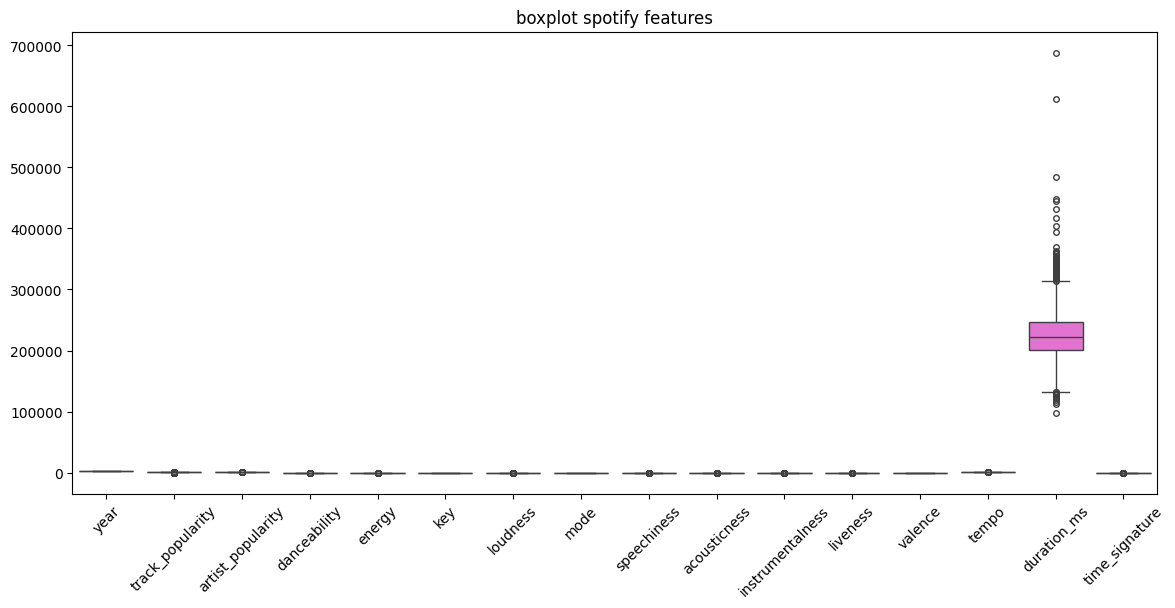

In [325]:
plt.figure(figsize=(14,6))
plt.title('boxplot spotify features')
data_box=sns.boxplot(data=data_spotify_copy,fliersize=4)  
plt.xticks(rotation=45)
plt.show()

# on voit clairement que la colonne duration_ms a des valeurs bien plus grandes que les autres(logique)
# prblm => les algo vont donner bcp plus de poids à cette colonne et invisibilise les autres features

Variances avant standardisation :
 year                 4.401696e+01
track_popularity     1.511436e+02
artist_popularity    1.483647e+02
danceability         1.991956e-02
energy               2.717159e-02
key                  1.316597e+01
loudness             4.329950e+00
mode                 2.403982e-01
speechiness          8.546066e-03
acousticness         4.155235e-02
instrumentalness     7.054317e-03
liveness             1.732375e-02
valence              5.190221e-02
tempo                7.627390e+02
duration_ms          1.769353e+09
time_signature       4.798469e-02
dtype: float64
Valeur moyenne de la variance 
 110584636.28505532


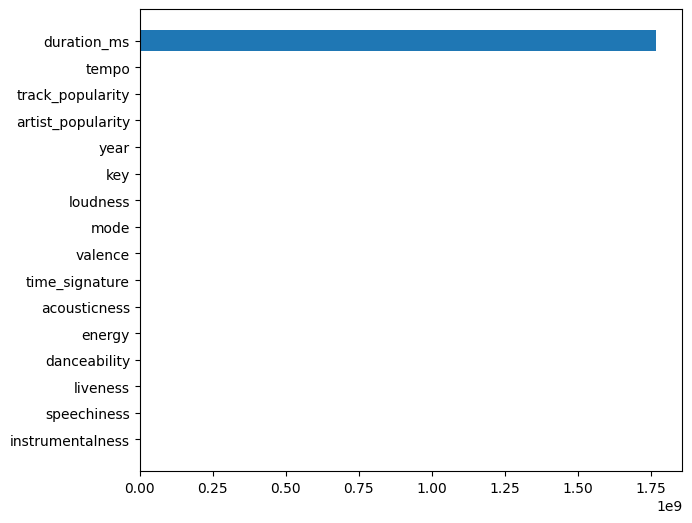

In [326]:
numeric_df = data_spotify_copy.select_dtypes(include=[float, int]) # on garde que les colonnes avec des valeurs numériques pour le calcul de la var
variances = numeric_df.var()
print("Variances avant standardisation :\n" , variances)

mean_var = numeric_df.var().mean() 
print('Valeur moyenne de la variance \n', mean_var)

# visualisation
plt.figure(figsize=(7,6))
plt.barh(numeric_df.var().sort_values().index, numeric_df.var().sort_values().values) # visualisation de la variance 
plt.show()

# la moyenne calculer est fortement influencée par la duration_ms, la variance est tellement élevée qu'elle invisibilise le reste des valeurs

In [327]:
skew_variables = numeric_df.skew().to_frame().rename(columns={0 :'skew'})  # calcul du skew de chaque colonne de numeric_df
print(skew_variables.sort_values('skew', ascending=False))

                       skew
instrumentalness   7.946269
liveness           1.997885
speechiness        1.920069
acousticness       1.823303
duration_ms        1.626116
tempo              0.553702
key                0.023334
year              -0.000866
valence           -0.076419
danceability      -0.398012
mode              -0.402227
artist_popularity -0.409799
energy            -0.630005
loudness          -1.247591
track_popularity  -2.341099
time_signature    -5.431689


In [328]:
highly_skewed = skew_variables[skew_variables['skew'] > 0.75] # si la varaiable est asymétrique à droite (très grandes valeurs)
lis = highly_skewed.index.to_list() # on réalise une liste des valeurs à transformer

print(lis) # on peut regarder ce qu'il y a dans la liste

for col in lis:
  numeric_df[col] = np.log1p(numeric_df[col]) # on transforme chaque colonne avec np.log1p pour réduire l'effet des outliers

['speechiness', 'acousticness', 'instrumentalness', 'liveness', 'duration_ms']


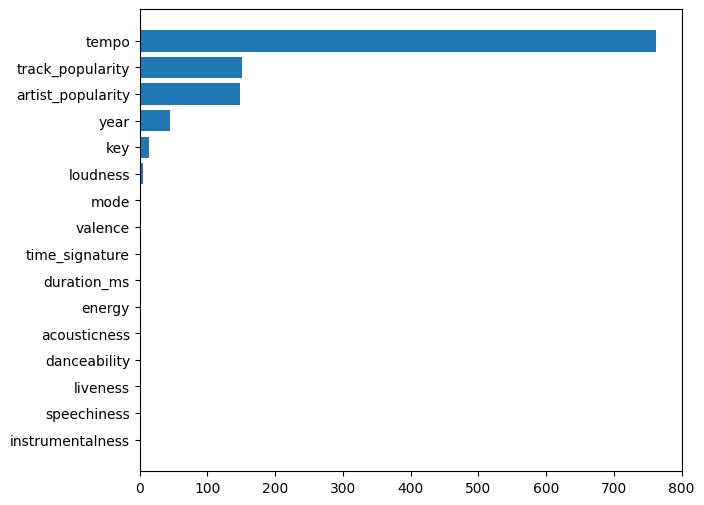

Variances :
 year                  44.016962
track_popularity     151.143596
artist_popularity    148.364737
danceability           0.019920
energy                 0.027172
key                   13.165967
loudness               4.329950
mode                   0.240398
speechiness            0.006169
acousticness           0.024440
instrumentalness       0.004141
liveness               0.010560
valence                0.051902
tempo                762.738973
duration_ms            0.031542
time_signature         0.047985
dtype: float64


In [329]:
# visualisation
plt.figure(figsize=(7,6))
plt.barh(numeric_df.var().sort_values().index, numeric_df.var().sort_values().values) # visualisation de la variance 
plt.show()

variances_2 = numeric_df.var()
print("Variances :\n" , variances_2)

# Variance faible => variables peu informatives, vairance élevée => variables discriminantes


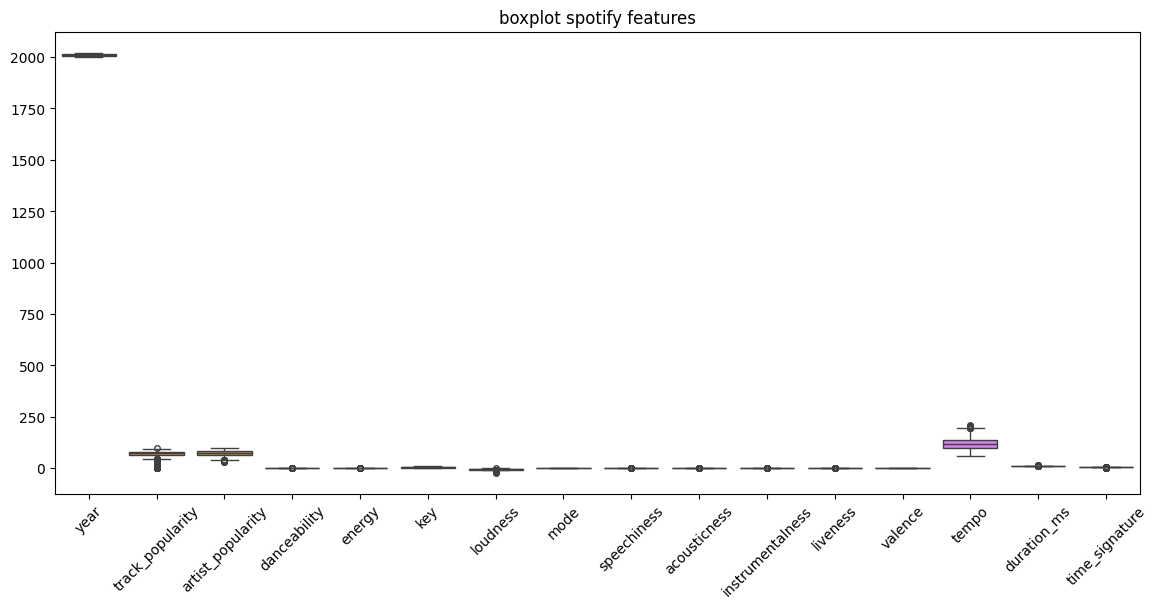

In [330]:
# visualisation
plt.figure(figsize=(14,6))
plt.title('boxplot spotify features')
data_box=sns.boxplot(data=numeric_df,fliersize=4)  
plt.xticks(rotation=45)
plt.show()

In [331]:
# pour étudier la corrélation
vif_data = pd.DataFrame()
vif_data["Feature"] = numeric_df.columns
vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) #calcul du Variance Inflation Factor pour chaque variable
                   for i in range(numeric_df.shape[1])]
print(vif_data)

# Chaque valeur correspond à une mesure de colinéarité entre une variable et toutes les autres du jeu de données
# Pour VIF > 10 => on a une grosse multicolinarité sérieuse à traiter (rétirer ou combiner)

              Feature          VIF
0                year  4743.757554
1    track_popularity    39.001634
2   artist_popularity    43.789712
3        danceability    33.229983
4              energy    50.263328
5                 key     3.206147
6            loudness    17.731128
7                mode     2.616238
8         speechiness     2.490479
9        acousticness     2.508465
10   instrumentalness     1.087604
11           liveness     3.375317
12            valence    10.088993
13              tempo    21.699637
14        duration_ms  4100.250945
15     time_signature   342.969919


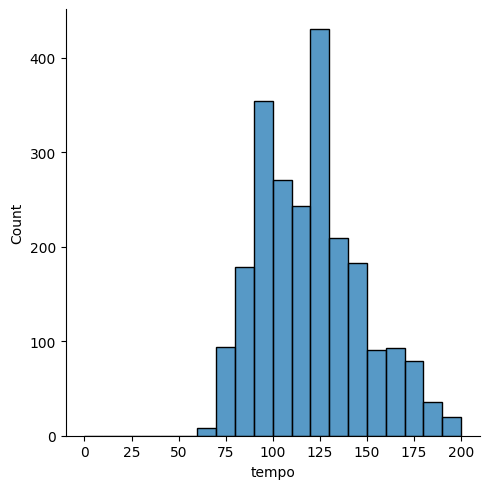

In [333]:
sns.displot(data=numeric_df,
            x='tempo',
            kind='hist',
            bins=np.arange(0,210, 10))


In [334]:
top_artists =data_spotify_copy.groupby('artist_name').max()['track_popularity'].to_frame().sort_values('track_popularity', ascending=False).head(10)
top_artists.head(10)

,track_popularity
artist_name,
Taylor Swift,100
David Guetta,93
Rema,92
The Weeknd,92
OneRepublic,92
Bizarrap,91
The Neighbourhood,91
Glass Animals,91
Coldplay,91
